# Analysis and visualization of daily growth rate of COVID-19 cases
Computing exponential growth rate of number of cases and visualize, comparing with DOW index

Read from data
https://covidtracking.com/api/v1/states/daily.csv
https://finance.yahoo.com/quote/%5EDJI/history/

In [13]:
import pandas as pd

dowDf = pd.read_csv("https://raw.githubusercontent.com/lamwilton/COVID-19/master/%5EDJI.csv")
covidDf = pd.read_csv("https://covidtracking.com/api/v1/states/daily.csv")

Cleaning/Compute Number of days

In [14]:
import datetime

day0 = datetime.date(2020, 1, 15)
covidDf['dateChecked'] = pd.to_datetime(covidDf['dateChecked']).dt.date
covidDf['day'] = (covidDf['dateChecked'] - day0).dt.days
dowDf['Date'] = pd.to_datetime(dowDf['Date']).dt.date
dowDf['Day'] = (dowDf['Date'] - day0).dt.days

Interpolating Dow index and plot with COVID data

<ipython-input-15-3e430adb9d10>:35: MatplotlibDeprecationWarning: Automatic legend placement (loc='best') not implemented for figure legend. Falling back on 'upper right'. This will raise an exception in 3.3.
  legend = fig.legend(loc=0)


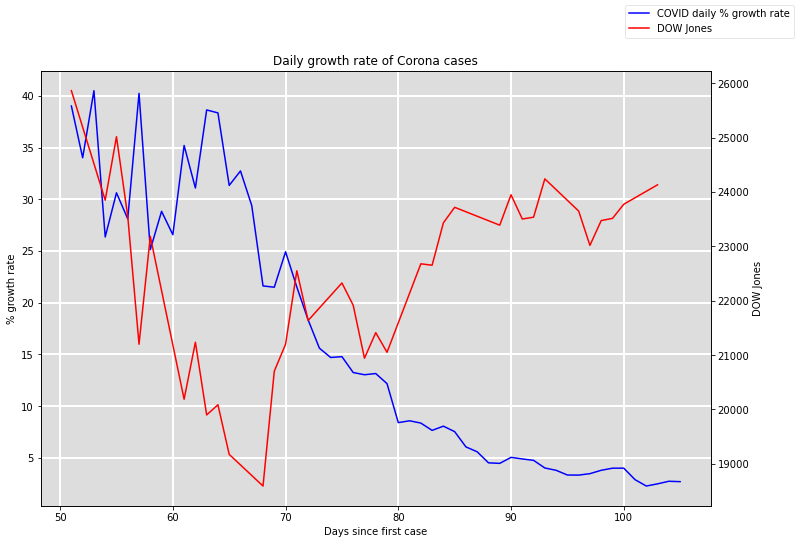

In [15]:
import matplotlib.pyplot as plt
import pandasql as ps
from scipy import interpolate


# Sum all states
sumDf = ps.sqldf("SELECT day, SUM(positive) as cases FROM covidDf GROUP BY dateChecked")
# Compute daily increases in cases and rate of increase
sumDf['dxdt'] = sumDf['cases'].diff()
sumDf['rate'] = sumDf['cases'].pct_change().fillna(0)
# Shift rate column up by 1
sumDf.rate = sumDf.rate.shift(-1)

# Remove DOW data before Covid19 appeared
sumDf = sumDf[sumDf.day > 50]
dowDf = dowDf[dowDf['Day'] > 50]

# Interpolate DOW using Cubic Splines
dowInter = interpolate.CubicSpline(dowDf['Day'], dowDf['Close'])

# Format plot
fig = plt.figure(facecolor='w', figsize=(12, 8))
ax = fig.add_subplot(111, axisbelow=True)
ax.set_facecolor('#dddddd')
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
ax.set_title("Daily growth rate of Corona cases")
ax.set_xlabel("Days since first case")
ax.set_ylabel("% growth rate")

# Plot
ax.plot(sumDf['day'], sumDf['rate'] * 100, 'b', label="COVID daily % growth rate")
ax2 = ax.twinx()
ax2.set_ylabel("DOW Jones")
ax2.plot(dowDf['Day'], dowInter(dowDf['Day']), 'r', label="DOW Jones")
legend = fig.legend(loc=0)
legend.get_frame().set_alpha(0.5)
plt.savefig('DOW.png', transperent=True)
plt.show()

Exponential curve fit of daily growth rate with national data

In [16]:
import numpy as np
from scipy.optimize import curve_fit


"""
Exponential fit
"""
# noinspection PyShadowingNames
def expo_fit(data):
    # Define exponential decay function
    # f(x) must be zero when x goes to infinity

    f = lambda x, a, c: a * np.exp(-c * (x - day_start))

    # Input data and fit
    xdata = np.array(data.day)
    ydata = np.array(data.rate)
    p0 = [0.1, 0.01]
    popt, pcov = curve_fit(f, xdata, ydata, p0=p0, maxfev=1000000)

    # Format regression plot
    fig2 = plt.figure(facecolor='w', figsize=(12, 8))
    ax = fig2.add_subplot(111, axisbelow=True)
    ax.set_facecolor('#dddddd')
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    ax.set_title("Daily growth rate of Corona cases")
    ax.set_xlabel("Days since first case")
    ax.set_ylabel("% growth rate")

    # Plot regression
    y_pred = f(xdata, *popt)
    ax.plot(xdata, y_pred)
    ax.plot(xdata, ydata)
    plt.show()
    return popt

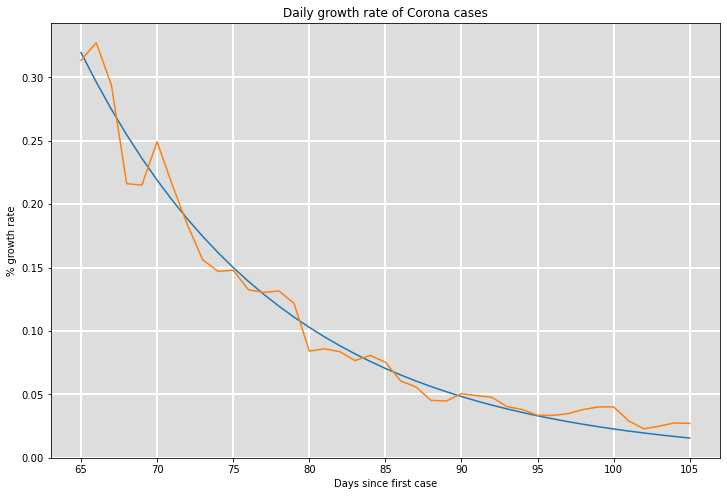

In [17]:
day_start = 65
# Fit between day_start and remove last day
popt = expo_fit(sumDf[(day_start <= sumDf.day) & (sumDf.day < sumDf.day.max())])

Set up differential equation and solve it, then plot the results
dy/dt = y * rate of growth

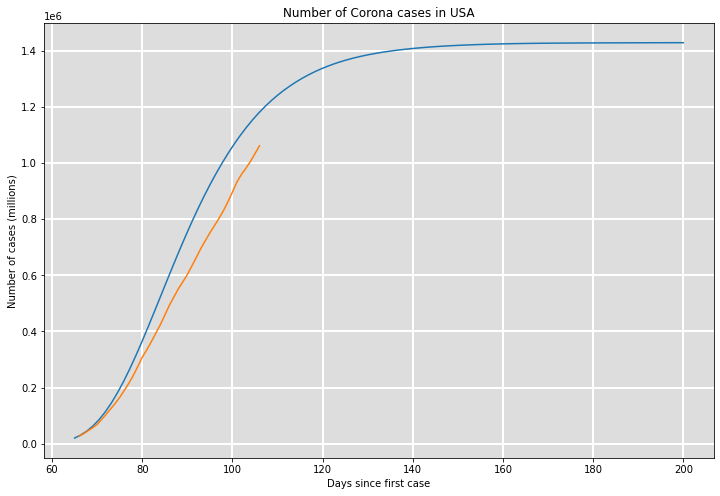

In [18]:
from scipy.integrate import solve_ivp

# Define differential equation
dydt = lambda t, y: y * popt[0] * np.exp(-popt[1] * (t - day_start))

# Solving differential equation
y0 = int(sumDf[sumDf.day == day_start].cases)
y_pred = solve_ivp(dydt, t_span=[day_start, 200], y0=[y0], t_eval=np.linspace(day_start, 200, 100))

# Plot formatting
fig3 = plt.figure(facecolor='w', figsize=(12, 8))
ax = fig3.add_subplot(111, axisbelow=True)
ax.set_facecolor('#dddddd')
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
ax.set_title("Number of Corona cases in USA")
ax.set_xlabel("Days since first case")
ax.set_ylabel("Number of cases (millions)")

# Plot
ax.plot(y_pred.t, np.array(y_pred.y).flatten())
ax.plot(sumDf.day[sumDf.day > day_start], sumDf.cases[sumDf.day > day_start])
plt.savefig('Expo_pred.png', transperent=True)
plt.show()

## State level data

In [19]:
def computeState(state):
    """
    Get cases and deaths of state, then interest rates
    :param state: State input
    :return: Cases and deaths as dataframes
    """
    stateDf = ps.sqldf("SELECT day, positive as cases FROM covidDf WHERE state = '" + state + "' ORDER BY dateChecked")
    # Compute daily increases in cases and rate of increase
    stateDf['dxdt'] = stateDf['cases'].diff()
    stateDf['rate'] = stateDf['cases'].pct_change().fillna(0)
    # Shift rate column up by 1
    sumDf.rate = sumDf.rate.shift(-1)

    return stateDf

Plotting CA rate

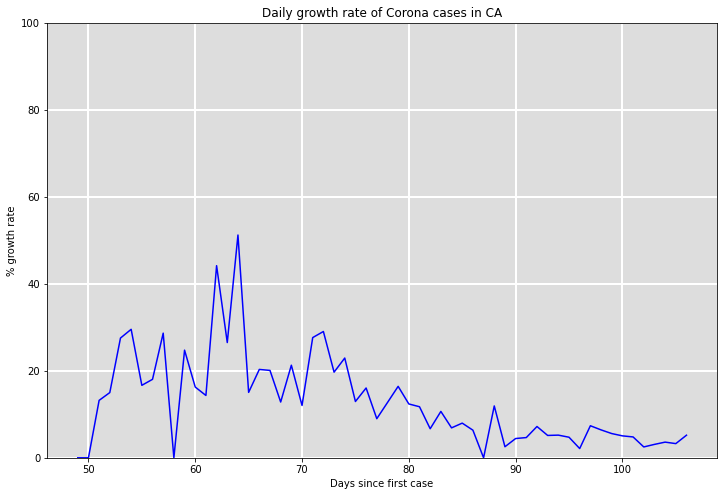

In [20]:
stateDf = computeState('CA')

fig = plt.figure(facecolor='w', figsize=(12, 8))

ax = fig.add_subplot(111, axisbelow=True)
ax.set_facecolor('#dddddd')
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
ax.set_title("Daily growth rate of Corona cases in CA")
ax.set_xlabel("Days since first case")
ax.set_ylabel("% growth rate")
ax.set_ylim(0, 100)
ax.plot(stateDf['day'], stateDf['rate'] * 100, 'b', label="COVID daily % growth rate")
plt.show()

Make a table of rates for all states, then create a Pseudocolor plot for all states

In [21]:
states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DE", "DC", "FL", "GA", "HI", "ID", "IL", "IN",
            "IA", "KS", "KY", "LA", "ME", "MD", "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH",
            "NJ", "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", "SD", "TN", "TX",
            "UT", "VT", "VA", "WA", "WV", "WI", "WY"]
rateTable, deathTable = pd.DataFrame(), pd.DataFrame
for i in range(len(states)):
    # Compute rates
    stateDf = computeState(states[i])
    rate = stateDf[['day', 'rate']]
    # deathrate = stateDf[['date', 'deathrateIncrease']]

    # Add result to rate tables
    if i <= 0:
        ratetable = rate
        # deathTable = deathrate
    else:
        ratetable = pd.merge(ratetable, rate, how='inner', on='day')
        # deathTable = pd.merge(deathTable, deathrate, how='inner', on='date')

# Rename columns
ratetable.columns = ['day', *states]
ratetable

,day,AL,AK,AZ,AR,CA,CO,CT,DE,DC,...,SD,TN,TX,UT,VT,VA,WA,WV,WI,WY
0,57,0.000000,0.000000,0.000000,inf,0.286624,0.607143,1.000000,3.000000,1.000000,...,0.600000,1.571429,0.095238,1.000000,1.000000,0.888889,0.145530,0.000000,1.666667,inf
1,58,inf,inf,0.000000,0.500000,0.000000,0.600000,0.000000,0.000000,0.000000,...,0.125000,0.444444,0.695652,0.500000,0.000000,0.764706,0.274047,0.000000,1.375000,0.000000
2,59,5.000000,0.000000,0.333333,0.333333,0.247525,0.402778,0.833333,0.500000,0.000000,...,0.000000,0.230769,0.307692,0.000000,1.000000,0.000000,0.148148,0.000000,0.000000,1.000000
3,60,1.000000,0.000000,0.000000,0.333333,0.162698,0.297030,0.818182,0.000000,0.600000,...,0.000000,0.218750,0.098039,3.666667,0.000000,0.500000,0.165012,0.000000,0.736842,0.500000
4,61,1.333333,0.000000,0.500000,0.375000,0.143345,0.000000,0.300000,0.333333,0.062500,...,0.111111,0.333333,0.017857,0.392857,1.000000,0.133333,0.136315,0.000000,0.424242,0.000000
5,62,0.285714,2.000000,0.111111,0.000000,0.441791,0.221374,0.576923,1.000000,0.294118,...,0.100000,0.403846,0.122807,0.307692,0.250000,0.313725,0.162137,0.000000,0.531915,2.333333
6,63,0.277778,1.000000,0.400000,0.500000,0.265010,0.143750,0.658537,0.562500,0.409091,...,0.000000,0.342466,0.296875,0.235294,0.900000,0.149254,0.140323,inf,0.472222,0.500000
7,64,0.478261,0.000000,0.571429,0.393939,0.512275,0.180328,0.411765,0.200000,0.258065,...,0.000000,0.571429,0.722892,0.238095,0.157895,0.220779,0.105375,1.000000,0.462264,0.200000
8,65,0.191176,1.000000,0.477273,1.086957,0.150433,0.282407,1.020833,0.266667,0.820513,...,0.272727,0.480519,0.356643,0.435897,0.318182,0.212766,0.154191,2.500000,0.329032,0.055556
9,66,0.530864,0.166667,0.600000,0.229167,0.203198,0.310469,0.000000,0.184211,0.084507,...,0.000000,0.627193,0.567010,0.214286,0.000000,0.333333,0.131929,0.571429,0.364078,0.210526


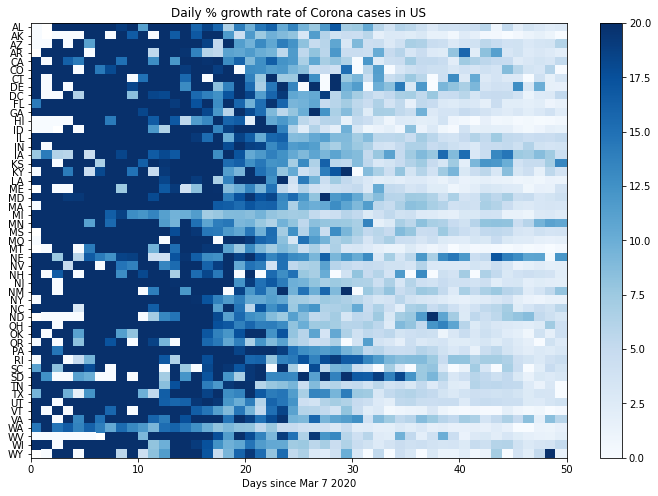

In [22]:
arr = np.array(ratetable.iloc[:, 1:])
# deatharr = np.array(deathTable.iloc[:, 1:])

fig = plt.figure(facecolor='w', figsize=(12, 8))
ax = fig.add_subplot(111, axisbelow=True)

# Set title and axis
ax.set_title("Daily % growth rate of Corona cases in US")
ax.set_xlabel("Days since Mar 7 2020")
ax.set_yticks(np.arange(len(states)) + 0.5)
ax.set_yticklabels(states)
ax.invert_yaxis()

# Plot heatmap
c = ax.pcolor(arr.T * 100, cmap='Blues', vmin=0, vmax=20)
fig.colorbar(c, ax=ax)
plt.savefig('US_rate.png', transperent=True)
plt.show()


Compute mean growth rate for 7 days of each state, then plot bar graph

In [23]:
mean_df = pd.DataFrame(ratetable.tail(7).mean())
mean_df = mean_df.drop('day', axis=0)
mean_df = mean_df.sort_values(by=0, ascending=False)
mean_df

,0
NE,0.111920
IA,0.089896
MN,0.083080
WY,0.082010
KS,0.079993
ND,0.060294
VA,0.058943
NM,0.055078
DE,0.053276
IL,0.052753


Text(0, 0.5, 'rate')

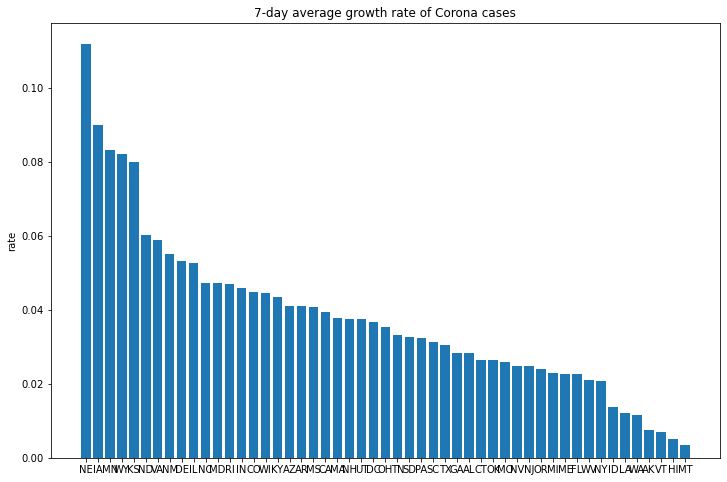

In [24]:
fig = plt.figure(facecolor='w', figsize=(12, 8))
ax:plt.axes = fig.add_subplot(111, axisbelow=True)
ax.bar(list(mean_df.index), mean_df.values.flatten())

ax.set_title("7-day average growth rate of Corona cases")
ax.set_ylabel("rate")

